In [1]:
%matplotlib inline


# GMM covariances


Demonstration of several covariances types for Gaussian mixture models.

See `gmm` for more information on the estimator.

Although GMM are often used for clustering, we can compare the obtained
clusters with the actual classes from the dataset. We initialize the means
of the Gaussians with the means of the classes from the training set to make
this comparison valid.

We plot predicted labels on both training and held out test data using a
variety of GMM covariance types on the iris dataset.
We compare GMMs with spherical, diagonal, full, and tied covariance
matrices in increasing order of performance. Although one would
expect full covariance to perform best in general, it is prone to
overfitting on small datasets and does not generalize well to held out
test data.

On the plots, train data is shown as dots, while test data is shown as
crosses. The iris dataset is four-dimensional. Only the first two
dimensions are shown here, and thus some points are separated in other
dimensions.



Automatically created module for IPython interactive environment
spherical
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.91621622 2.77297297 4.25945946 1.32432432]
 [6.59459459 2.98378378 5.51351351 2.02432432]]
----
diag
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.91621622 2.77297297 4.25945946 1.32432432]
 [6.59459459 2.98378378 5.51351351 2.02432432]]
----
tied
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.91621622 2.77297297 4.25945946 1.32432432]
 [6.59459459 2.98378378 5.51351351 2.02432432]]
----
full
[[5.04594595 3.46486486 1.46216216 0.25945946]
 [5.91621622 2.77297297 4.25945946 1.32432432]
 [6.59459459 2.98378378 5.51351351 2.02432432]]
----


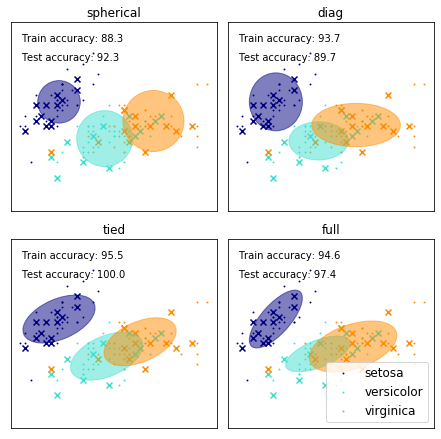

In [7]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

use_mean = True

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    if use_mean:
        estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])
    print(name)
    print(np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)]))
    print("----")

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()